<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Swiss-population-mortality-rates" data-toc-modified-id="Swiss-population-mortality-rates-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Swiss population mortality rates</a></span><ul class="toc-item"><li><span><a href="#Human-mortality-database" data-toc-modified-id="Human-mortality-database-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Human mortality database</a></span></li><li><span><a href="#Lee-Carter-model" data-toc-modified-id="Lee-Carter-model-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Lee-Carter model</a></span></li></ul></li><li><span><a href="#Recurrent-Neural-Networks" data-toc-modified-id="Recurrent-Neural-Networks-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Recurrent Neural Networks</a></span></li><li><span><a href="#Implementation-of-recurrent-neural-networks" data-toc-modified-id="Implementation-of-recurrent-neural-networks-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Implementation of recurrent neural networks</a></span><ul class="toc-item"><li><span><a href="#Using-keras" data-toc-modified-id="Using-keras-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Using <code>keras</code></a></span></li><li><span><a href="#Toy-example-for-the-use-of-LSTM-and-GRU-models" data-toc-modified-id="Toy-example-for-the-use-of-LSTM-and-GRU-models-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Toy example for the use of LSTM and GRU models</a></span><ul class="toc-item"><li><span><a href="#Comparison-of-LSTMs-and-GRUs" data-toc-modified-id="Comparison-of-LSTMs-and-GRUs-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Comparison of LSTMs and GRUs</a></span></li><li><span><a href="#Choices-of-hyperparameters" data-toc-modified-id="Choices-of-hyperparameters-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>Choices of hyperparameters</a></span></li><li><span><a href="#Time-distributed-LSTM-layers" data-toc-modified-id="Time-distributed-LSTM-layers-3.2.3"><span class="toc-item-num">3.2.3&nbsp;&nbsp;</span>Time-distributed LSTM layers</a></span></li></ul></li></ul></li><li><span><a href="#Mortality-rate-predictions-with-LSTM-and-GRU-models" data-toc-modified-id="Mortality-rate-predictions-with-LSTM-and-GRU-models-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Mortality rate predictions with LSTM and GRU models</a></span><ul class="toc-item"><li><span><a href="#Data-pre-processing-for-RNNs" data-toc-modified-id="Data-pre-processing-for-RNNs-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Data pre-processing for RNNs</a></span></li><li><span><a href="#Recurrent-neural-networks-on-individual-genders" data-toc-modified-id="Recurrent-neural-networks-on-individual-genders-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Recurrent neural networks on individual genders</a></span></li><li><span><a href="#Modelling-both-genders-simultaneously" data-toc-modified-id="Modelling-both-genders-simultaneously-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Modelling both genders simultaneously</a></span></li><li><span><a href="#Robustness-of-the-recurrent-neural-network-solution" data-toc-modified-id="Robustness-of-the-recurrent-neural-network-solution-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Robustness of the recurrent neural network solution</a></span></li></ul></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Conclusions</a></span></li></ul></div>

**Python implementation of following paper**

Richman, Ronald and Wuthrich, Mario V., Lee and Carter go Machine Learning: Recurrent Neural Networks (August 22, 2019). Available at SSRN: https://ssrn.com/abstract=3441030 or http://dx.doi.org/10.2139/ssrn.3441030


In [2]:
import io
import requests
import pandas as pd
import numpy as np

#import statistical packages
from scipy.linalg import svd
from statsmodels.tsa.arima_model import ARIMA

#import plotting libraries
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

# Swiss population mortality rates
## Human mortality database

Read data

In [13]:
mx_m = pd.read_csv('data/mx_m.csv')
mx_y = pd.read_csv('data/mx_f.csv')

source: https://www.mortality.org

Clean mortality data

In [17]:
def clean_mort_data(df):
    new_df = df.replace('.', np.nan).astype(np.float32)
    #delete raw mortality rates that are greater than 1
    new_df[new_df >= 1] = 0.99999999
    #get only ages up to age 99
    new_df = new_df.iloc[range(100),:]
    #if 0 for ages between 0 - 100 then perform forward fill and backward fill
    new_df[new_df == 0] = np.nan
    new_df = new_df.fillna(method='ffill').fillna(method='bfill')
    return new_df
mort_data_f = clean_mort_data(mx_f)
mort_data_m = clean_mort_data(mx_m)

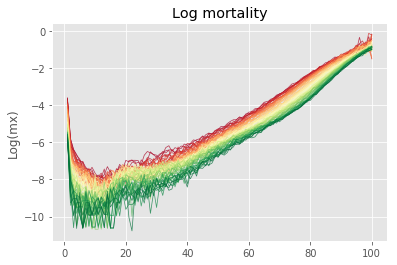

In [18]:
def plot_mort_data(df):
    log_mort_data = np.log(df)
    log_mort_data.plot(kind='line', colormap='RdYlGn', legend=False, alpha=0.75, linewidth=0.75);
    plt.title('Log mortality')
    plt.ylabel('Log(mx)')
    plt.show()
plot_mort_data(mort_data_f)

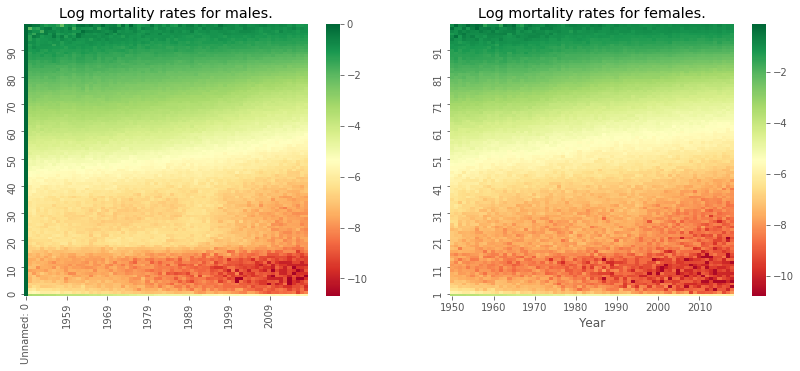

In [19]:
mort_data_log_m = np.log(mort_data_m)
mort_data_log_f = np.log(mort_data_f)

fig, axs = plt.subplots(ncols=2, figsize=(14,5))
sns.heatmap(mort_data_log_m, cmap='RdYlGn', ax = axs[0], xticklabels=10, yticklabels=10).invert_yaxis() #sns.lineplot(np.arange(0, len(ax)), ax).set(title='$a_x$', xlabel='Age')
sns.heatmap(mort_data_log_f, cmap='RdYlGn', ax = axs[1], xticklabels=10, yticklabels=10).invert_yaxis() #sns.lineplot(np.arange(0, len(bx)), bx).set(title='$b_x$', xlabel='Age')
axs[0].set_title('Log mortality rates for males.')
axs[1].set_title('Log mortality rates for females.')
plt.show()

Train test split

In [21]:
def train_test_split_lc(df, train_end_year = 2000):
    min_year = int(df.columns.min())
    max_year = int(df.columns.max())
    train_mort_data = df.loc[:, range(min_year, train_end_year)]
    test_mort_data = df.loc[:, range(train_end_year, max_year)]
    return train_mort_data, test_mort_data
train_data, test_data = train_test_split_lc(mort_data_f, 2000)

In [22]:
train_data.head()

Year,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
1,0.027293,0.026030,0.025850,0.025878,0.024316,0.023881,0.022860,0.020115,0.019257,0.018591,...,0.006430,0.005405,0.005382,0.005240,0.004519,0.004472,0.004077,0.004687,0.003981,0.003848
2,0.003046,0.002946,0.002538,0.002046,0.002098,0.002710,0.001961,0.002253,0.001762,0.001817,...,0.000488,0.000650,0.000684,0.000810,0.000436,0.000373,0.000275,0.000475,0.000353,0.000388
3,0.001674,0.001691,0.001441,0.001601,0.001536,0.001430,0.000838,0.001166,0.000716,0.001285,...,0.000238,0.000612,0.000297,0.000290,0.000426,0.000169,0.000348,0.000151,0.000226,0.000177
4,0.001234,0.001283,0.000951,0.001063,0.000997,0.000879,0.000937,0.000816,0.000904,0.000818,...,0.000217,0.000130,0.000075,0.000416,0.000144,0.000070,0.000288,0.000249,0.000075,0.000251
5,0.001007,0.000893,0.000963,0.000631,0.000936,0.000796,0.000527,0.000865,0.000771,0.000591,...,0.000270,0.000266,0.000077,0.000149,0.000194,0.000119,0.000117,0.000096,0.000150,0.000126


## Lee-Carter model

In [23]:
class LC():
    def __init__(self):
        self.ax = None
        self.bx = None
        self.kt = None
        self.kt_preds = None
        self.training_data = None
        self._is_predicted = False
        self._is_fitted = False
        self.fitted = pd.DataFrame()
    
    def mse(self, mortality_matrix):
        if self._is_fitted:
            se = (self.fitted - mortality_matrix) ** 2
            mse = se.mean().mean()
            return mse
    
    def fit(self, mortality_matrix):
        
        if not self._is_fitted:
    
            self.training_data = mortality_matrix
            
            log_mort = np.log(mortality_matrix)
            ax = log_mort.sum(axis=1) / log_mort.shape[1]
            train_mort = log_mort.subtract(ax, axis='rows')
            train_mort.replace([np.inf, -np.inf], np.nan, inplace=True)

            #fit LC model by using Singular Value Decomposition
            U, S, VT = svd(train_mort)
            bx = U[:, 0] * S[0]
            kt = VT[0]

            c1 = kt.mean()
            c2 = bx.sum()
            bx /= c2
            kt = (kt-c1)*c2

            self.ax, self.bx, self.kt = pd.Series(ax, index=mortality_matrix.index), pd.Series(bx, index=mortality_matrix.index), pd.Series(kt, index=mortality_matrix.columns)
        
            #calculate fitted mortality rates
            log_m = ax.values.reshape(-1,1) + bx.reshape(-1,1) @ kt.reshape(1,-1)
            
            m = np.exp(log_m)
            
            self.fitted = pd.DataFrame(m, columns = mortality_matrix.columns)
            
            self._is_fitted = True
        
        print("Model fitted.")
    
    def predict(self, steps=10):
        kt_f = ARIMA(self.kt, order=(0,1,0))
        kt_fit = kt_f.fit(disp=0)
        kt_preds = kt_fit.forecast(steps=steps)[0]
        self.kt_preds = pd.Series(kt_preds, index=range(self.training_data.columns.max() + 1, self.training_data.columns.max() + 1 + steps))
        self._is_predicted = True
                                  
    def plot(self):
        fig, axs = plt.subplots(ncols=3, figsize=(14,5))
        sns.lineplot(self.ax.index, self.ax, ax=axs[0]).set(title='$a_x$', xlabel='Age')
        sns.lineplot(self.bx.index, self.bx, ax=axs[1]).set(title='$b_x$', xlabel='Age')
        sns.scatterplot(self.training_data.columns, self.kt, ax=axs[2]).set(title='$k_t$', xlabel='Year')
        if self._is_predicted == True:
            sns.scatterplot(self.kt_preds.index, self.kt_preds, ax=axs[2], color='green')

        fig.suptitle('Fitted parameters of Lee-Carter model for period {} to {}.'.format(self.training_data.columns.min(), self.training_data.columns.max()), fontsize=14);

In [24]:
#Define and fit the model
lc = LC()
lc.fit(train_data)

Model fitted.


In [25]:
#Plot MSE for fitted (in-sample) data
lc.mse(train_data)

0.000301481137285009

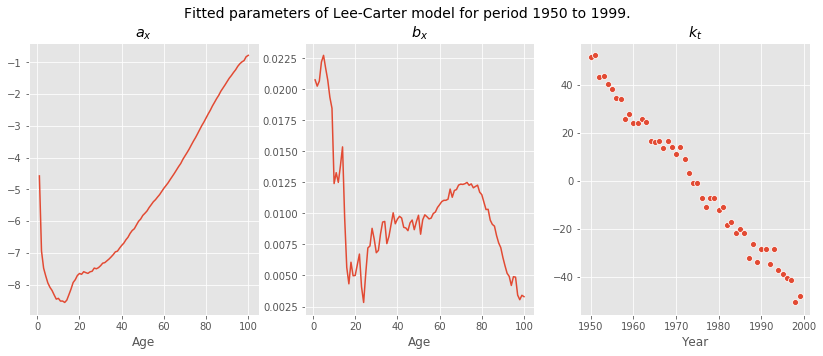

In [26]:
#Plot fitted values
lc.plot()

In [27]:
lc.fitted.head()

Year,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,0.030035,0.030462,0.025265,0.025525,0.023838,0.022842,0.021065,0.020898,0.017614,0.018368,...,0.005697,0.005720,0.005008,0.005735,0.004768,0.004595,0.004454,0.004355,0.003602,0.003819
1,0.002755,0.002794,0.002328,0.002351,0.002199,0.002110,0.001949,0.001934,0.001637,0.001705,...,0.000544,0.000546,0.000480,0.000548,0.000458,0.000441,0.000428,0.000419,0.000348,0.000368
2,0.001638,0.001662,0.001379,0.001394,0.001302,0.001248,0.001151,0.001142,0.000963,0.001004,...,0.000313,0.000314,0.000275,0.000315,0.000262,0.000253,0.000245,0.000240,0.000198,0.000210
3,0.001389,0.001410,0.001154,0.001167,0.001085,0.001036,0.000950,0.000942,0.000785,0.000821,...,0.000235,0.000236,0.000204,0.000236,0.000194,0.000186,0.000180,0.000176,0.000144,0.000153
4,0.001146,0.001163,0.000948,0.000959,0.000889,0.000849,0.000777,0.000770,0.000639,0.000669,...,0.000185,0.000186,0.000161,0.000187,0.000153,0.000147,0.000142,0.000138,0.000112,0.000120


In [31]:
lc.predict(steps=20)

C:\Users\TOMAS529\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\TOMAS529\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


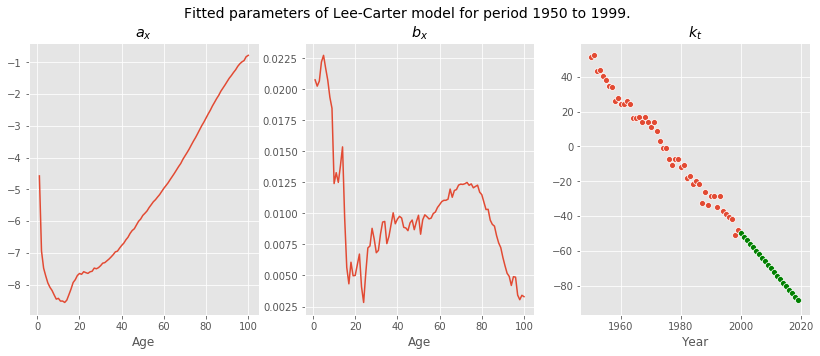

In [32]:
lc.plot()

# Recurrent Neural Networks

# Implementation of recurrent neural networks

In [33]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import LSTM, Dense, InputLayer, Input, TimeDistributed, GRU
from keras.models import Sequential, Model

Using TensorFlow backend.


In [34]:
print(f'Tensorflow version {tf.__version__}')
print(f'Keras version {keras.__version__}')

Tensorflow version 1.13.1
Keras version 2.2.4-tf


## Using `keras`

In [35]:
def dnn_constructor(name, layer_type, T, tau_0, tau_1, tau_2=None):
    
    if layer_type != 'LSTM' and layer_type != 'GRU' and layer_type != 'FNN':
        print(f'Layer {layer_type} not recognised. Possible choice [LSTM, GRU, FNN]')
        pass

    if layer_type == 'FNN':
        input_layer = Input(shape=(T*tau_0,), dtype=np.float32, name='Input')   
    else:
        input_layer = Input(shape=(T, tau_0), dtype=np.float32, name='Input')    
    
    if tau_2 != None:
        if layer_type == 'LSTM':
            hidden_layer = LSTM(tau_1, activation='tanh', recurrent_activation='tanh', return_sequences=True, name=layer_type+'1')(input_layer)
            hidden_layer = LSTM(tau_2, activation='tanh', recurrent_activation='tanh', name=layer_type+'2')(hidden_layer)
        elif layer_type == 'GRU':
            hidden_layer = GRU(tau_1, activation='tanh', recurrent_activation='tanh', return_sequences=True, name=layer_type+'1')(input_layer)
            hidden_layer = GRU(tau_2, activation='tanh', recurrent_activation='tanh', name=layer_type+'2')(hidden_layer)
        else:
            hidden_layer = Dense(tau_1, activation='tanh', name=layer_type+'1')(input_layer)
            hidden_layer = Dense(tau_2, activation='tanh', name=layer_type+'2')(hidden_layer)            
    else:
        if layer_type == 'LSTM':
            hidden_layer = LSTM(tau_1, activation='tanh', recurrent_activation='tanh', name=layer_type+'1')(input_layer)
        elif layer_type == 'GRU':
            hidden_layer = GRU(tau_1, activation='tanh', recurrent_activation='tanh', name=layer_type+'1')(input_layer)
        else:
            hidden_layer = Dense(tau_1, activation='tanh', name=layer_type+'1')(input_layer)            
            
    output_layer = Dense(1, activation='exponential', name='Output')(hidden_layer)
    dnn_model = Model(inputs=input_layer, outputs=output_layer, name=name)
    dnn_model.compile(optimizer='nadam',
                 loss='mean_squared_error')

    return dnn_model

In [36]:
T = 10 #loockback period
tau_0 = 3 #age window to smooth raw mortality rates
tau_1 = 5 #first hidden layer
tau_2 = 4 #second hidden layer

In [37]:
lstm1 = dnn_constructor('lstm_1l', 'LSTM', T, tau_0, tau_1)
lstm1.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 10, 3)             0         
_________________________________________________________________
LSTM1 (LSTM)                 (None, 5)                 180       
_________________________________________________________________
Output (Dense)               (None, 1)                 6         
Total params: 186
Trainable params: 186
Non-trainable params: 0
_________________________________________________________________


In [38]:
lstm2 = dnn_constructor('lstm_2l', 'LSTM', T, tau_0, tau_1, tau_2)
lstm2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 10, 3)             0         
_________________________________________________________________
LSTM1 (LSTM)                 (None, 10, 5)             180       
_________________________________________________________________
LSTM2 (LSTM)                 (None, 4)                 160       
_________________________________________________________________
Output (Dense)               (None, 1)                 5         
Total params: 345
Trainable params: 345
Non-trainable params: 0
_________________________________________________________________


In [39]:
inputs = Input(shape=(T, tau_0), dtype=np.float32, name='Input')
x = LSTM(tau_1, activation='tanh', recurrent_activation='tanh', return_sequences=True, name='LSTM1')(inputs)
predictions = TimeDistributed(Dense(1, activation='exponential', name='Output'), name='TD')(x)

model3 = Model(inputs=inputs, outputs=predictions)

model3.compile(optimizer='nadam',
             loss='mean_squared_error')

model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 10, 3)             0         
_________________________________________________________________
LSTM1 (LSTM)                 (None, 10, 5)             180       
_________________________________________________________________
TD (TimeDistributed)         (None, 10, 1)             6         
Total params: 186
Trainable params: 186
Non-trainable params: 0
_________________________________________________________________


In [40]:
gru1 = dnn_constructor('gru_1l', 'GRU', T, tau_0, tau_1)
gru1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 10, 3)             0         
_________________________________________________________________
GRU1 (GRU)                   (None, 5)                 135       
_________________________________________________________________
Output (Dense)               (None, 1)                 6         
Total params: 141
Trainable params: 141
Non-trainable params: 0
_________________________________________________________________


In [41]:
gru2 = dnn_constructor('gru_2l', 'GRU', T, tau_0, tau_1, tau_2)
gru2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 10, 3)             0         
_________________________________________________________________
GRU1 (GRU)                   (None, 10, 5)             135       
_________________________________________________________________
GRU2 (GRU)                   (None, 4)                 120       
_________________________________________________________________
Output (Dense)               (None, 1)                 5         
Total params: 260
Trainable params: 260
Non-trainable params: 0
_________________________________________________________________


## Toy example for the use of LSTM and GRU models

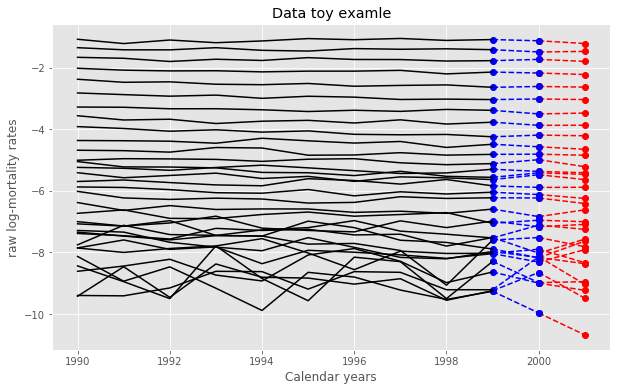

In [42]:
step = range(1,100,3)
plt.figure(figsize=(10,6))
plot_valid_2 = np.log(mort_data_f).loc[step,range(2000, 2002)].T
plot_valid_1 = np.log(mort_data_f).loc[step,range(1999, 2001)].T
plot_test = np.log(mort_data_f).loc[step,range(1990, 2000)].T
plt.plot(plot_valid_2, 'r--o')
plt.plot(plot_valid_1, 'b--o')
plt.plot(plot_test, 'k-')
plt.title('Data toy examle')
plt.xlabel('Calendar years')
plt.ylabel('raw log-mortality rates')
plt.show()

In [43]:
def extract_age_windows(df, n):
    min_age = df.index.min()
    max_age = df.index.max()
    dfs = []
    pad = int((n - 1) / 2)
    if pad > 0:
        df = pd.concat([pd.concat([df.iloc[:1]]*pad), df]) # pad first row
        df = pd.concat([df, pd.concat([df.iloc[-1:]]*pad)]) # pad last row 
    for i in range(min_age+pad-1, max_age+pad):
        dfs.append(df.iloc[range(i-pad,i+pad+1)].T.values)
    dfs = np.array(dfs)
    return dfs

def prepare_data(df, T=10, tau_0=3, end_year=2000):
    
    #get an appropriate window of raw mortality data
    data = np.log(df).iloc[range(0,100)].loc[:, range(end_year-T,end_year+1)]
    x_train = np.log(df).iloc[range(0,100)].loc[:, range(end_year-T,end_year)]
    y_train = np.log(df).iloc[range(0,100)].loc[:, end_year]
    x_test = np.log(df).iloc[range(0,100)].loc[:, range(end_year-T+1,end_year+1)]
    y_test = np.log(df).iloc[range(0,100)].loc[:, end_year+1]
     
    #MinMaxScaler
    min_xt = data.min().min()
    max_xt = data.max().max()
    
    x_train = 2 * (x_train - min_xt) / (max_xt - min_xt) - 1
    x_test = 2 * (x_test - min_xt) / (max_xt - min_xt) - 1
    
    y_train = - y_train.iloc[range(0,100)].values
    y_test = - y_test.iloc[range(0,100)].values
    
    #get appropriate age window for smoothing of raw mortality rates
    train_data = extract_age_windows(x_train, tau_0)
    test_data = extract_age_windows(x_test, tau_0)
    
    return train_data, y_train, test_data, y_test

In [44]:
x_train, y_train, x_test, y_test = prepare_data(mort_data_f, T=10, tau_0=3)

In [45]:
print(f'Shape of x_train {x_train.shape}, shape of x_test {x_test.shape}')
print(f'Shape of y_train {y_train.shape}, shape of y_test {y_test.shape}')

Shape of x_train (100, 10, 3), shape of x_test (100, 10, 3)
Shape of y_train (100,), shape of y_test (100,)


### Comparison of LSTMs and GRUs

Fit model.

In [46]:
def plot_model_fit(model):
    n_epochs = len(model.history.history['loss'])
    plt.scatter(range(n_epochs), model.history.history['loss'], s=4, c='blue', label = 'Training loss')
    plt.scatter(range(n_epochs), model.history.history['val_loss'], s=4, c='red', label = 'Validation loss')
    plt.title('Test and valuation sets loss.')
    plt.ylabel('MSE')
    plt.xlabel('Epoch')
    plt.ylim((0,0.2))
    plt.hlines(0.1, xmin=0, xmax=n_epochs, linestyles='dotted')
    plt.legend()
    plt.show()

In [47]:
lstm1 = dnn_constructor('lstm_1l', 'LSTM', T, tau_0, tau_1)
lstm1.fit(x=x_train, y=y_train, validation_data=(x_test, y_test), batch_size=10, epochs=500, verbose=0)

Instructions for updating:
Use tf.cast instead.


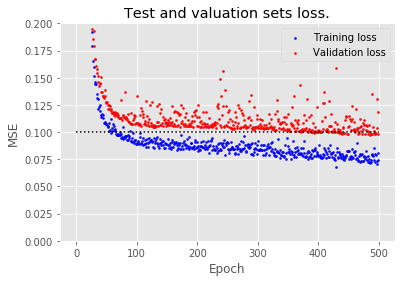

In [48]:
plot_model_fit(lstm1)

In [49]:
lstm2 = dnn_constructor('lstm_2l', 'LSTM', T, tau_0, tau_1, tau_2)
lstm2.fit(x=x_train, y=y_train, validation_data=(x_test, y_test), batch_size=10, epochs=500, verbose=0)

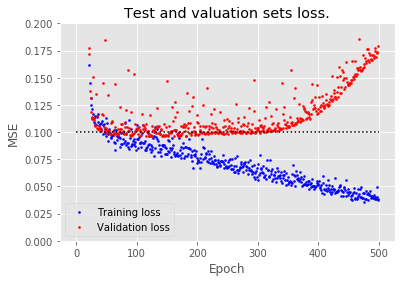

In [50]:
plot_model_fit(lstm2)

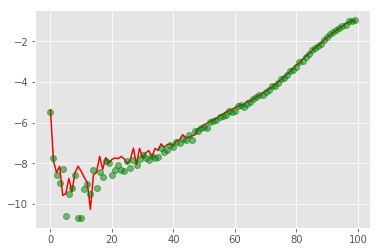

In [51]:
plt.plot(- lstm2.predict(x_test), 'r-')
plt.plot(- y_test, 'go', alpha=.5)
plt.show()

In [52]:
gru1 = dnn_constructor('gru_1l', 'GRU', T, tau_0, tau_1)
gru1.fit(x=x_train, y=y_train, validation_data=(x_test, y_test), batch_size=10, epochs=500, verbose=0)

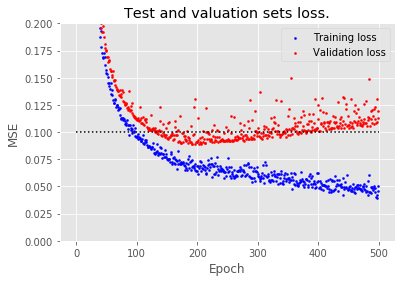

In [53]:
plot_model_fit(gru1)

In [54]:
gru2 = dnn_constructor('gru_2l', 'GRU', T, tau_0, tau_1, tau_2)
gru2.fit(x=x_train, y=y_train, validation_data=(x_test, y_test), batch_size=10, epochs=500, verbose=0)

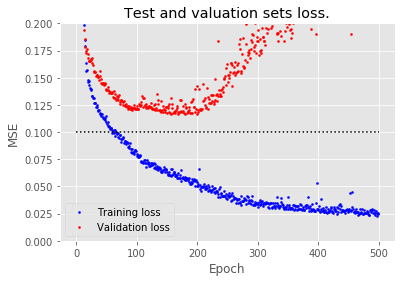

In [55]:
plot_model_fit(gru2)

In [56]:
fnn2 = dnn_constructor('fnn_2l', 'FNN', T, tau_0, tau_1, tau_2)
fnn2.fit(x=x_train.reshape(-1, T * tau_0), y=y_train, validation_data=(x_test.reshape(-1, T * tau_0), y_test), batch_size=10, epochs=500, verbose=0)

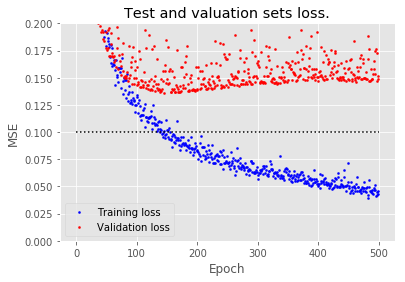

In [57]:
plot_model_fit(fnn2)

In [58]:
def plot_results(models):
    #concatenate all results into one df
    models_df = []
    for m in models:
        model_df = pd.DataFrame(m.history.history, columns=['loss'])
        model_df.columns = ['value']
        model_df['model'] = m.name
        model_df['epoch'] = range(1,model_df.shape[0]+1)
        model_df['loss_type'] = 'loss'
        models_df.append(model_df)

        model_df = pd.DataFrame(m.history.history, columns=['val_loss'])
        model_df.columns = ['value']
        model_df['model'] = m.name
        model_df['epoch'] = range(1,model_df.shape[0]+1)    
        model_df['loss_type'] = 'val_loss'
        models_df.append(model_df)
    models_df = pd.concat(models_df)
    
    #plot results
    g = sns.FacetGrid(models_df, palette='Set1', col="model", hue="loss_type")
    g.map(plt.scatter, "epoch", "value", alpha=.5, s=5)
    plt.ylim(0, 0.2)
    g.add_legend();

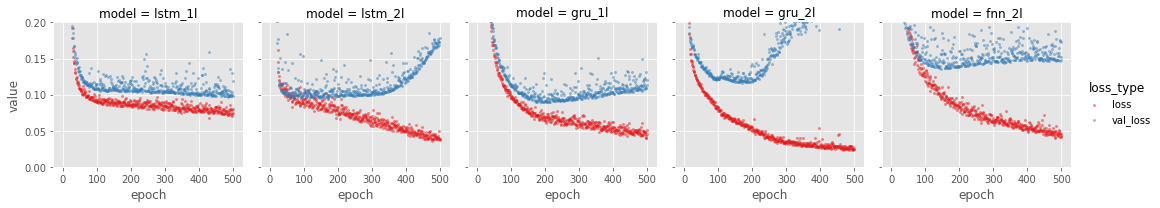

In [59]:
models = [lstm1, lstm2, gru1, gru2, fnn2]
plot_results(models)

### Choices of hyperparameters

In [60]:
#base case: T = 10, tau_0 = 3, tau_1 = 5

`tau_0 = 1,5`

In [61]:
x_train, y_train, x_test, y_test = prepare_data(mort_data_f, T=10, tau_0=1)
lstm1_tau_0_1 = dnn_constructor('lstm_tau_0_1', 'LSTM', T, tau_0=1, tau_1=5)
lstm1_tau_0_1.fit(x=x_train, y=y_train, validation_data=(x_test, y_test), batch_size=10, epochs=500, verbose=0)

In [62]:
x_train, y_train, x_test, y_test = prepare_data(mort_data_f, T=10, tau_0=5)
lstm1_tau_0_5 = dnn_constructor('lstm_tau_0_5', 'LSTM', T, tau_0=5, tau_1=5)
lstm1_tau_0_5.fit(x=x_train, y=y_train, validation_data=(x_test, y_test), batch_size=10, epochs=500, verbose=0)

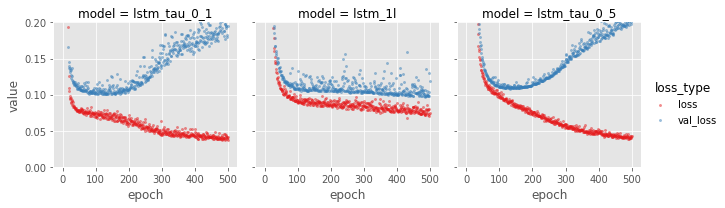

In [63]:
models = [lstm1_tau_0_1, lstm1, lstm1_tau_0_5]
plot_results(models)

`T = 5, 20`

In [64]:
x_train, y_train, x_test, y_test = prepare_data(mort_data_f, T=5, tau_0=3)
lstm1_T_5 = dnn_constructor('lstm_T_5', 'LSTM', T=5, tau_0=3, tau_1=5)
lstm1_T_5.fit(x=x_train, y=y_train, validation_data=(x_test, y_test), batch_size=5, epochs=500, verbose=0)

In [65]:
x_train, y_train, x_test, y_test = prepare_data(mort_data_f, T=20, tau_0=3)
lstm1_T_20 = dnn_constructor('lstm_T_20', 'LSTM', T=20, tau_0=3, tau_1=5)
lstm1_T_20.fit(x=x_train, y=y_train, validation_data=(x_test, y_test), batch_size=20, epochs=500, verbose=0)

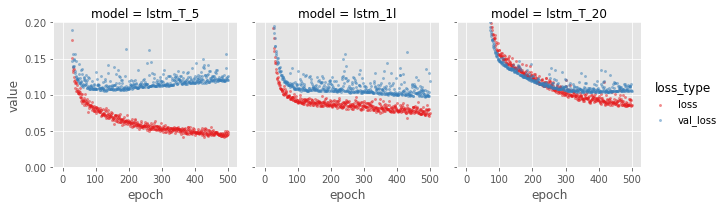

In [66]:
models = [lstm1_T_5, lstm1, lstm1_T_20]
plot_results(models)

### Time-distributed LSTM layers

# Mortality rate predictions with LSTM and GRU models

## Data pre-processing for RNNs

## Recurrent neural networks on individual genders

## Modelling both genders simultaneously

## Robustness of the recurrent neural network solution

# Conclusions